In [1]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve, cross_validate
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import warnings

In [2]:
import optuna
optuna.__version__

'3.2.0'

In [3]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [4]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
df.head()

,date,title,reason,description,zone,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,...,embeddings_title,tfidf_keywords,embeddings_keywords,events_clean,results_final,events_tfidf,events_embeddings,orgs,locs,entities
0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,...,ctt - encomenda entregue danificada e com etiq...,apresentar reclamação caixa figura envio israe...,apresentar uma reclamação tinha caixa figura e...,venho apresentar enviei destinado feito proteg...,"[('CTT', 'B-ORGANIZACAO'), ('Israel', 'B-LOCAL...",venho apresentar enviar destinar fazer protege...,venho apresentar enviei destinado feito proteg...,"CTT, Aboboda",Israel,"CTT, Aboboda, Israel"
1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,1,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! Venho por este meio reclamar que ...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,...,ctt - carta com certificado rasgado !,lilia pimentel certificar profissional passage...,lilia pimentel certificado profissional passag...,venho reclamar deparei -me continha tem,"[('Lilia', 'B-PESSOA'), ('Pimentel', 'I-PESSOA')]",venho reclamar deparar conter,venho reclamar deparei - me continha tem,NaN,NaN,NaN
2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,2,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,...,ctt - encomenda registada que nunca chegou ao ...,frança correio registar frança correio encomen...,frança em correio registado frança em correio ...,enviei registado vejo chegou saiu chegou tem p...,"[('França', 'B-LOCAL'), ('Roissy', 'B-ORGANIZA...",enviar registar vejo chegar sair chegar passar...,enviei registado vejo chegou saiu chegou tem p...,Roissy,"França, ROISSY","Roissy, França, ROISSY"
3,2018-04-19 09:04:34,CTT - Correio Verde,2,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...",...,ctt - correio verde,pretender esclarecer situação pretender esclar...,pretendia esclarecer uma situação pretendia es...,pretendia esclarecer ocorreu desloquei dado fe...,"[('El', 'B-LOCAL'), ('Corte', 'I-LOCAL'), ('In...",pretender esclarecer ocorrer desloquei dar fec...,pretendia esclarecer ocorreu desloquei dado fe...,Correio,"El Corte Inglés, Lisboa Verde","Correio, El Corte Inglés, Lisboa Verde"
4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",2,venho por este meio solicitar a vossa ajuda pa...,Porto,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...",...,"ctt - aviso de recepção da carta registada , p...",papal centro pois preciso urgentemente pois pr...,papais para o centro pois preciso dele urgente...,venho solicitar saber onde se encontra regista...,[],venho solicitar saber onde encontrar registar ...,venho solicitar saber onde se encontra regista...,NaN,NaN,NaN


In [5]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [6]:
df['entities']

0                          israel aboboda ctt
1                                        None
2                               frança roissy
3        verde lisboa correio corte inglés el
4                                        None
                         ...                 
22425                reino portugal unido ctt
22426                                    None
22427                              aliexpress
22428                                  lisboa
22429                                    None
Name: entities, Length: 22430, dtype: object

In [7]:
df.columns

Index(['date', 'title', 'reason', 'description', 'zone', 'narrative_tfidf',
       'narrative_embeddings', 'narrative_bert', 'narrative_tfidf_title',
       'narrative_bert_title', 'narrative_embeddings_title', 'tfidf_title',
       'title_tfidf_nolemma', 'events', 'keywords', 'embeddings_title',
       'tfidf_keywords', 'embeddings_keywords', 'events_clean',
       'results_final', 'events_tfidf', 'events_embeddings', 'orgs', 'locs',
       'entities'],
      dtype='object')

In [8]:
y=df['reason']
X = df[['narrative_tfidf', 'tfidf_title', 'tfidf_keywords', 'events_tfidf', 'entities']]

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 5)
y_train shape: (15701,)
X_val shape: (3364, 5)
y_val shape: (3364,)
X_test shape: (3365, 5)
y_test shape: (3365,)


In [10]:
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = pd.concat([y_train, y_val], axis=0, ignore_index=True)

In [11]:
# Plot Learning Curves
def plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, scoring):
    # Create StratifiedKFold cross-validator with 6 folds
    stratified_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_val_combined_transformed, y_train_val, cv=stratified_cv,
                                                           scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10),
                                                           random_state=42, n_jobs=-1)

    # Calculate mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(val_scores, axis=1)
    valid_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2, color='red')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('{} Score'.format(scoring))
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# <span style="color:white; font-size:18px;background-color:red"> Default XGBoost HT</span> 
done

In [14]:
def objective(trial):
    feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # Transform the features using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
    X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
    X_test_combined_transformed = vectorizer.transform(X_test_combined)

    # Define the hyperparameter search space
    params = {
      'objective': 'multi:softmax',
      'num_class': 4,
      'eval_metric': 'mlogloss',
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
      'gamma': trial.suggest_float("gamma", 0, 1),
      'random_state': 42,  # Add other hyperparameters as needed
      'reg_alpha': trial.suggest_float('reg_alpha',0, 1),              # L1 regularization term on weights
      'reg_lambda': trial.suggest_float('reg_lambda',0, 1)
    }

    # Create and train the XGBoost classifier with the current set of hyperparameters
    clf = XGBClassifier(**params)
    clf.fit(X_train_val_combined_transformed, y_train_val)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro', n_jobs=-1)

    return f1_scores.mean()

In [ ]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'description_title_keywords.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [ ]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='description_title_keywords',load_if_exists=True)
study.optimize(objective, n_trials=50)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-07-30 01:05:39,386] A new study created in RDB with name: description_title_keywords
[I 2023-07-30 01:46:59,940] Trial 0 finished with value: 0.45076536635853826 and parameters: {'colsample_bytree': 0.8481781819826891, 'eta': 0.024914580506785078, 'gamma': 0.600195402231574, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 692, 'reg_alpha': 0.5941382665998689, 'reg_lambda': 0.289947460352284, 'subsample': 0.5247350747360959}. Best is trial 0 with value: 0.45076536635853826.
[I 2023-07-30 02:09:46,554] Trial 1 finished with value: 0.4702032121386974 and parameters: {'colsample_bytree': 0.7612560333215546, 'eta': 0.20632398379829894, 'gamma': 0.13331133924189265, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 458, 'reg_alpha': 0.533366102451221, 'reg_lambda': 0.4725380046619754, 'subsample': 0.8383017824580684}. Best is trial 1 with value: 0.4702032121386974.
[I 2023-07-30 02:41:03,255] Trial 2 finished with value: 0.45874055358778176 and parameters: {'colsample_b

Val Loss: 0.4734151878989077
Best hyperparameters: {'colsample_bytree': 0.6660707896339382, 'eta': 0.1865203620258158, 'gamma': 0.4869470425232074, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 747, 'reg_alpha': 0.2615683528029101, 'reg_lambda': 0.20706126430246635, 'subsample': 0.87307714888806}


In [ ]:
# in case it fails
# Load the existing study by providing the study name and storage URL
study = optuna.load_study(study_name='description_title_keywords', storage=storage)

# Continue optimization with additional trials
study.optimize(objective, n_trials=50)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
study = optuna.load_study(study_name='description_title_keywords', storage=storage)
import optuna.visualization as vis
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_optimization_history(study)

In [15]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

params={'colsample_bytree': 0.6660707896339382, 'eta': 0.1865203620258158, 'gamma': 0.4869470425232074, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 747, 'reg_alpha': 0.2615683528029101, 'reg_lambda': 0.20706126430246635, 'subsample': 0.87307714888806}
best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)

metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# Perform cross-validation for different metrics
for metric in metrics:
    scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual f1_macro scores: [0.47180509 0.47844127 0.4683652  0.48459997 0.47082927 0.46645033]
Mean cross-validation f1_macro: 0.4734151878989077
Individual accuracy scores: [0.65481435 0.65859031 0.65544368 0.65596475 0.65942713 0.65533522]
Mean cross-validation accuracy: 0.6565959055538618
Individual recall_macro scores: [0.45825772 0.46444297 0.45641166 0.46823135 0.45719147 0.45526274]
Mean cross-validation recall_macro: 0.45996631687575484
Individual precision_macro scores: [0.52845456 0.53595292 0.52228523 0.55657497 0.53461912 0.51930991]
Mean cross-validation precision_macro: 0.5328661174804752


test classification report
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1195
           1       0.29      0.13      0.18       333
           2       0.73      0.83      0.78      1609
           3       0.39      0.19      0.25       228

    accuracy                           0.64      3365
   macro avg       0.50      0.44      0.45      3365
weighted avg       0.61      0.64      0.62      3365



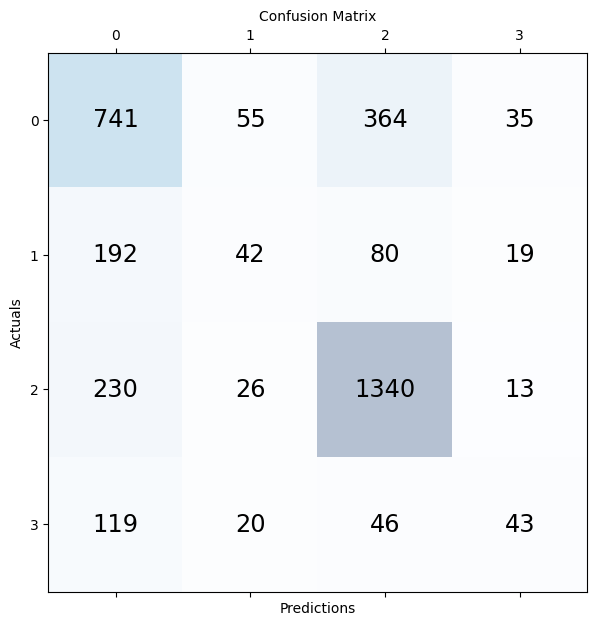

In [16]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_combined_transformed, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

In [ ]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'f1_macro')

In [ ]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'accuracy')

# <span style="color:white; font-size:18px;background-color:red"> Class Weighting + HT</span>  
https://machinelearningmastery.com/xgboost-for-imbalanced-classification/  
https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310  

 

done, db in colab

In [ ]:
from collections import Counter
for target, count in Counter(df['reason']).items():
    print('Class {} represents {} % of the dataset.'.format(target, round((count/len(df))*100,1)))

Class 0 represents 35.5 % of the dataset.
Class 1 represents 9.9 % of the dataset.
Class 2 represents 47.8 % of the dataset.
Class 3 represents 6.8 % of the dataset.


In [15]:
def BalancedSampleWeights(y_train_val,class_weight_coef):
    class_weight_dict = {
    0: len(y_train_val) / (4 * sum(y_train_val == 0)),
    1: len(y_train_val) / (4 * sum(y_train_val == 1)),
    2: len(y_train_val) / (4 * sum(y_train_val == 2)),
    3: len(y_train_val) / (4 * sum(y_train_val == 3))
}
    class_weight_dict = {key: value * class_weight_coef for key, value in class_weight_dict.items()}
    sample_weights = [class_weight_dict[i] for i in y_train_val]
    return sample_weights
weight=BalancedSampleWeights(y_train_val,1)

1. The class weights are calculated by dividing the total number of samples by the product of the number of classes and the number of samples in each class. This will assign smaller weights to the classes with larger sample counts and higher weights to the classes with smaller sample counts, so that the algorithm pays more attention to the minority class during training. Class weights are typically assigned at the class level and are used to modify the loss function during training. Models with class weights will penalize misclassifications of the minority class more heavily, effectively giving more importance to correctly classifying the minority class.  

      class_weight = total_samples / (num_classes * class_samples)


2. sample_weights is used to give weights for each training sample. That means that you should pass a one-dimensional array with the exact same number of elements as your training samples. These weights determine the importance of each sample during the training process. By assigning different weights to different samples, you can control how much emphasis the algorithm places on each sample while learning. This can be useful for scenarios where certain samples are more informative or more representative of the population than others.  


3. The class_weight_coef parameter determines how much you want to scale the calculated class weights. Examples:

  * class_weight_coef = 1 (No Scaling):
  When class_weight_coef is set to 1, it means you're using the calculated class weights as they are, without any modification. The impact of this is that your model will be trained with class weights that are directly proportional to the inverse class frequencies in your dataset. This can help the model pay more attention to minority classes and less attention to the majority class.

  * class_weight_coef > 1 (Scaling Up):
  When class_weight_coef is greater than 1 (e.g., 2), you're scaling up the calculated class weights. This will increase the importance of the class weights during training. The impact is that your model will be even more sensitive to the minority classes, potentially leading to better performance on these classes. However, it might also increase the risk of overfitting to the minority classes, especially if they are represented by noisy or less representative data.

  * class_weight_coef < 1 (Scaling Down):
  When class_weight_coef is less than 1 (e.g., 0.5), you're scaling down the calculated class weights. This will decrease the importance of the class weights during training. The impact is that your model might become less sensitive to the minority classes and could potentially perform worse on them. However, this might help mitigate the risk of overfitting to the minority classes and might result in better generalization to the majority class.







In [17]:
def objective(trial):
    feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # Transform the features using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
    X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
    X_test_combined_transformed = vectorizer.transform(X_test_combined)

    # Define the hyperparameter search space
    params = {
      'objective': 'multi:softmax',
      'num_class': 4,
      'eval_metric': 'mlogloss',
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
      'gamma': trial.suggest_float("gamma", 0, 1),
      'reg_alpha': trial.suggest_float('reg_alpha',0, 1),              # L1 regularization term on weights
      'reg_lambda': trial.suggest_float('reg_lambda',0, 1)
    }

    # Create and train the XGBoost classifier with the current set of hyperparameters
    clf = XGBClassifier(**params, random_state=42)
    clf.fit(X_train_val_combined_transformed, y_train_val)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro',fit_params={'sample_weight': weight}, n_jobs=-1)
    # f1_scores = cross_validate(clf, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro', fit_params={'sample_weight': weight}, n_jobs=-1)
    return f1_scores.mean()

In [18]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'tfidf_xgboost.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [ ]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='tfidf_xgboost',load_if_exists=True)
study.optimize(objective, n_trials=50, n_jobs=2)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-09-01 02:03:43,246] A new study created in RDB with name: tfidf_xgboost
[I 2023-09-01 03:49:55,632] Trial 1 finished with value: 0.4861196054410757 and parameters: {'eta': 0.26743777616461495, 'n_estimators': 312, 'max_depth': 3, 'subsample': 0.6149439212243977, 'colsample_bytree': 0.9309596812315835, 'min_child_weight': 14, 'gamma': 0.46397707096244345, 'reg_alpha': 0.16565222305887106, 'reg_lambda': 0.7059422177618105}. Best is trial 1 with value: 0.4861196054410757.


In [ ]:
# in case it fails
# Load the existing study by providing the study name and storage URL
study = optuna.load_study(study_name='tfidf_xgboost', storage=storage)

# Continue optimization with additional trials
study.optimize(objective, n_trials=4, n_jobs=2)

trial = study.best_trial
print('F1 score Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [19]:
study = optuna.load_study(study_name='tfidf_xgboost', storage=storage)
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [20]:
trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Val Loss: 0.49837307828527727
Best hyperparameters: {'eta': 0.11707214843748354, 'n_estimators': 683, 'max_depth': 4, 'subsample': 0.8052358910657191, 'colsample_bytree': 0.6375469658962902, 'min_child_weight': 11, 'gamma': 0.5125568365432647, 'reg_alpha': 0.7065018181023835, 'reg_lambda': 0.6334284370858739}


In [ ]:
params= {'eta': 0.11707214843748354, 'n_estimators': 683, 'max_depth': 4, 'subsample': 0.8052358910657191, 'colsample_bytree': 0.6375469658962902, 'min_child_weight': 11, 'gamma': 0.5125568365432647, 'reg_alpha': 0.7065018181023835, 'reg_lambda': 0.6334284370858739}

best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring=metric, fit_params={'sample_weight': weight}, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual f1_macro scores: [0.48818601 0.50745187 0.49029414 0.50209929 0.50797808 0.49422909]
Mean cross-validation f1_macro: 0.49837307828527727
Individual accuracy scores: [0.60572687 0.62303335 0.60604154 0.61252754 0.62448851 0.61315707]
Mean cross-validation accuracy: 0.6141624802349116
Individual recall_macro scores: [0.50043146 0.52024473 0.50477435 0.51329925 0.52231749 0.51035374]
Mean cross-validation recall_macro: 0.511903504854152


In [16]:
params= {'eta': 0.11707214843748354, 'n_estimators': 683, 'max_depth': 4, 'subsample': 0.8052358910657191, 'colsample_bytree': 0.6375469658962902, 'min_child_weight': 11, 'gamma': 0.5125568365432647, 'reg_alpha': 0.7065018181023835, 'reg_lambda': 0.6334284370858739}

best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# Perform cross-validation for different metrics
metrics = ['precision_macro']
for metric in metrics:
    scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring=metric, fit_params={'sample_weight': weight}, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual precision_macro scores: [0.48121846 0.49951346 0.48190727 0.49434896 0.49977845 0.48530668]
Mean cross-validation precision_macro: 0.4903455475935597


test classification report
              precision    recall  f1-score   support

           0       0.60      0.50      0.55      1195
           1       0.24      0.29      0.26       333
           2       0.76      0.78      0.77      1609
           3       0.33      0.43      0.37       228

    accuracy                           0.61      3365
   macro avg       0.48      0.50      0.49      3365
weighted avg       0.62      0.61      0.61      3365



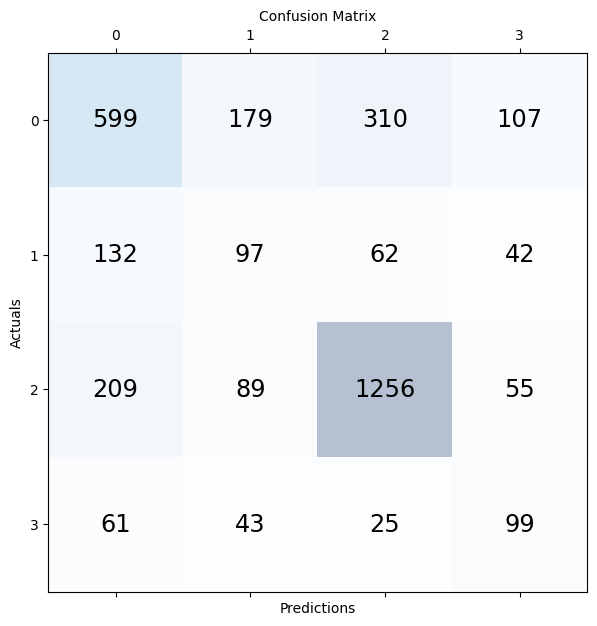

In [17]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_combined_transformed, y_train_val, sample_weight= weight)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

In [ ]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'f1_macro')

In [ ]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'accuracy')

# <span style="color:white; font-size:18px;background-color:red"> SMOTE + HT</span>  
using the best hyperparameters found first and training with Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance  
* use the sampling_strategy as 'not majority', which focuses on resampling all classes except the majority class  
* classes 0 and 2 are resampled to have a similar proportion to the majority class (class 2), while class 1 and class 3 are still resampled, but with a slightly reduced ratio. By doing this, we effectively focus on balancing classes 0 and 2 while also considering the hierarchy among classes, which can help prevent overfitting on the minority classes.  
sampling_strategy = {0: 0.478, 2: 0.478, 1: 0.355, 3: 0.355}


In [17]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'tfidf_xgboost_smote.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [ ]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

smote=SMOTE(random_state=42, sampling_strategy='not majority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_val_combined_transformed, y_train_val)

In [18]:
def objective(trial):
    feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # Transform the features using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
    X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
    X_test_combined_transformed = vectorizer.transform(X_test_combined)

    smote=SMOTE(random_state=42, sampling_strategy='not majority')
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_val_combined_transformed, y_train_val)

    # Define the hyperparameter search space
    params = {
      'objective': 'multi:softmax',
      'num_class': 4,
      'eval_metric': 'mlogloss',
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
      'gamma': trial.suggest_float("gamma", 0, 1),
      'random_state': 42,  # Add other hyperparameters as needed
      'reg_alpha': trial.suggest_float('reg_alpha',0, 1),              # L1 regularization term on weights
      'reg_lambda': trial.suggest_float('reg_lambda',0, 1)
    }

    # Create and train the XGBoost classifier with the current set of hyperparameters
    clf = XGBClassifier(**params)
    clf.fit(X_train_balanced, y_train_balanced)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=cv, scoring='f1_macro', n_jobs=-1)

    return f1_scores.mean()

In [ ]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='tfidf_xgboost_smote',load_if_exists=True)
study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2023-09-05 20:58:48,310] A new study created in RDB with name: tfidf_xgboost_smote
[I 2023-09-05 23:06:00,256] Trial 3 finished with value: 0.7833562197561759 and parameters: {'colsample_bytree': 0.8476323221403206, 'eta': 0.09251377909735288, 'gamma': 0.5944768352009022, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 264, 'reg_alpha': 0.9310537018870306, 'reg_lambda': 0.6517129934429988, 'subsample': 0.7005920972222206}. Best is trial 3 with value: 0.7833562197561759.
[I 2023-09-06 00:52:55,185] Trial 2 finished with value: 0.8202117839581313 and parameters: {'colsample_bytree': 0.791460541742687, 'eta': 0.2981134299841235, 'gamma': 0.910154800229377, 'max_depth': 12, 'min_child_weight': 12, 'n_estimators': 328, 'reg_alpha': 0.4315788873408122, 'reg_lambda': 0.3578672954725932, 'subsample': 0.6791602710509828}. Best is trial 2 with value: 0.8202117839581313.
[I 2023-09-06 02:56:14,151] Trial 1 finished with value: 0.8155072387080439 and parameters: {'colsample_bytree': 0.71

In [ ]:
study = optuna.load_study(study_name='tfidf_xgboost_smote', storage=storage)
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
# in case it fails
# Load the existing study by providing the study name and storage URL
study = optuna.load_study(study_name='tfidf_xgboost_smote', storage=storage)

# Continue optimization with additional trials
study.optimize(objective, n_trials=30, n_jobs=-1)

In [ ]:
trial = study.best_trial
params=study.best_trial
best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)
print('F1 score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
acc=cross_val_score(best_model,  X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy', n_jobs=-1)
print('accuracy: ',acc)

In [ ]:
params=
best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    scores = cross_val_score(best_model,  X_train_balanced, y_train_balanced, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

In [ ]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'f1_macro')

In [ ]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'accuracy')

In [ ]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

# <span style="color:white; font-size:18px;background-color:red"> ADASYN + HT </span>

# <span style="color:white; font-size:18px;background-color:red"> chi-square feature selection + HT </span>

In [ ]:
import optuna
def objective2(trial):
    feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # Transform the features using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
    X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
    X_test_combined_transformed = vectorizer.transform(X_test_combined)

    # Nr features before
    feature_names = vectorizer.get_feature_names_out()
    num_features_before = len(feature_names)

    # Define the hyperparameter search space
    params = {
      'objective': 'multi:softmax',
      'num_class': 4,
      'eval_metric': 'mlogloss',
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
      'gamma': trial.suggest_float("gamma", 0, 1),
      'random_state': 42,  # Add other hyperparameters as needed
      'reg_alpha': trial.suggest_float('reg_alpha',0, 1),              # L1 regularization term on weights
      'reg_lambda': trial.suggest_float('reg_lambda',0, 1)
    }

    # Create and train the XGBoost classifier with the current set of hyperparameters
    clf = XGBClassifier(**params)

    # Perform feature selection with SelectKBest and chi2 score function
    best_k = trial.suggest_int('best_k', 100, (num_features_before// 2) + 1, step=100)
    selector = SelectKBest(score_func=chi2, k=best_k)
    X_train_selected = selector.fit_transform(X_train_val_combined_transformed, y_train_val)

    clf.fit(X_train_selected, y_train_val)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_selected, y_train_val, cv=cv, scoring='f1_macro', n_jobs=-1)

    return f1_scores.mean()

In [ ]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'description_title_keywords_chi2.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [ ]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='description_title_keywords_chi2',load_if_exists=True)
study.optimize(objective2, n_trials=50)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-01 04:35:23,619] A new study created in RDB with name: description_title_keywords_chi2
[I 2023-08-01 05:00:01,174] Trial 0 finished with value: 0.4758071270411723 and parameters: {'best_k': 19000, 'colsample_bytree': 0.6372300556489741, 'eta': 0.11634639083843275, 'gamma': 0.8059270570286402, 'max_depth': 14, 'min_child_weight': 11, 'n_estimators': 509, 'reg_alpha': 0.2129975897120766, 'reg_lambda': 0.4663462522099917, 'subsample': 0.936800957190444}. Best is trial 0 with value: 0.4758071270411723.
[I 2023-08-01 05:43:32,758] Trial 1 finished with value: 0.46736828918724466 and parameters: {'best_k': 59500, 'colsample_bytree': 0.901007355749329, 'eta': 0.13106513399634534, 'gamma': 0.04272235841699601, 'max_depth': 11, 'min_child_weight': 12, 'n_estimators': 864, 'reg_alpha': 0.04254157813403281, 'reg_lambda': 0.8515520173741137, 'subsample': 0.5588638079969619}. Best is trial 0 with value: 0.4758071270411723.
[I 2023-08-01 06:14:46,715] Trial 2 finished with value: 0.473108

Val Loss: 0.47945427309192024
Best hyperparameters: {'best_k': 20100, 'colsample_bytree': 0.6512388819343109, 'eta': 0.2011426906334458, 'gamma': 0.7620849043646142, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 715, 'reg_alpha': 0.5168759646324439, 'reg_lambda': 0.39913638872637947, 'subsample': 0.9273881699037634}


In [12]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Perform feature selection with SelectKBest and chi2 score function
selector = SelectKBest(score_func=chi2, k=20100)
X_train_selected = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
X_test_selected = selector.transform(X_test_combined_transformed)

params={'colsample_bytree': 0.6512388819343109, 'eta': 0.2011426906334458, 'gamma': 0.7620849043646142, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 715, 'reg_alpha': 0.5168759646324439, 'reg_lambda': 0.39913638872637947, 'subsample': 0.9273881699037634}
best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    scores = cross_val_score(best_model,  X_train_selected, y_train_val, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual f1_macro scores: [0.47395958 0.48409438 0.48514985 0.4810824  0.48361073 0.46882871]
Mean cross-validation f1_macro: 0.47945427309192024
Individual accuracy scores: [0.64789176 0.66299559 0.65544368 0.65313189 0.66383381 0.65502046]
Mean cross-validation accuracy: 0.6563861960431329
Individual recall_macro scores: [0.4599011  0.46880402 0.46947879 0.46518119 0.46812514 0.45753012]
Mean cross-validation recall_macro: 0.46483672598718284
Individual precision_macro scores: [0.52595034 0.54429817 0.54621095 0.56436488 0.54869362 0.51672214]
Mean cross-validation precision_macro: 0.5410400153386702


test classification report
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1195
           1       0.33      0.12      0.18       333
           2       0.72      0.83      0.77      1609
           3       0.41      0.24      0.30       228

    accuracy                           0.64      3365
   macro avg       0.51      0.45      0.46      3365
weighted avg       0.61      0.64      0.62      3365



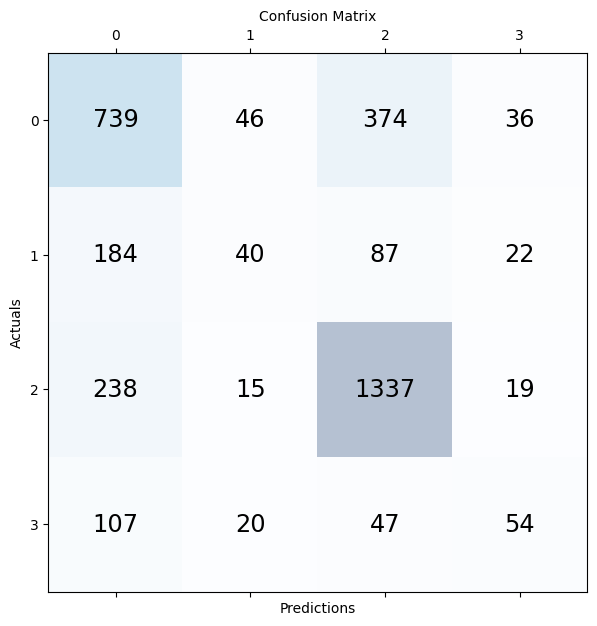

In [13]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_selected, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_selected)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

In [ ]:
plot_learning_curve(best_model, X_train_selected, y_train_val, 'accuracy')

In [ ]:
plot_learning_curve(best_model, X_train_selected, y_train_val, 'f1_macro')

# <span style="color:white; font-size:18px;background-color:red"> feature importance + hyperparameter tuning</span>

In [16]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

#best params of HT alone
params={'colsample_bytree': 0.6660707896339382, 'eta': 0.1865203620258158, 'gamma': 0.4869470425232074, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 747, 'reg_alpha': 0.2615683528029101, 'reg_lambda': 0.20706126430246635, 'subsample': 0.87307714888806}
best_model = XGBClassifier(objective= 'multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42, **params)
best_model.fit(X_train_val_combined_transformed, y_train_val)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6660707896339382, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1865203620258158,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.4869470425232074, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=8, missing=nan,
              monotone_constraints=None, n_estimators=747, n_jobs=None,
              num_class=4, num_parallel_tree=None, ...)

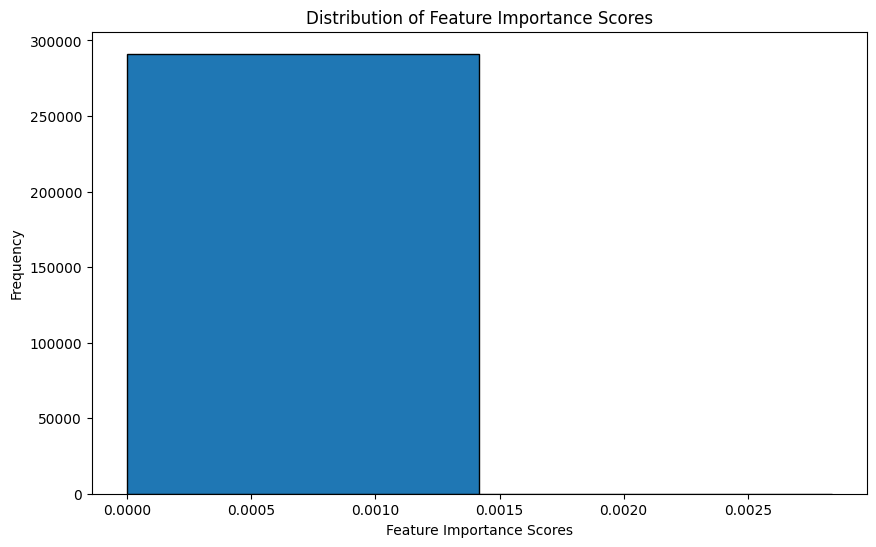

In [22]:
feature_importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.hist(feature_importances, bins=2, edgecolor='k')
plt.xlabel('Feature Importance Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Importance Scores')
plt.show()

majority of feature importance scores are close to zero which suggests that most of the features in the dataset do not significantly contribute to the model's predictions

In [26]:
# Select the top N features based on importance
threshold = 0.0005
feature_importances = best_model.feature_importances_
top_feature_indices = np.where(feature_importances > threshold)[0]
X_train_selected = X_train_val_combined_transformed[:, top_feature_indices]
X_test_selected = X_test_combined_transformed[:, top_feature_indices]

# train again
best_model.fit(X_train_selected, y_train_val)
metrics = ['f1_macro', 'accuracy']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_selected, y_train_val, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual f1_macro scores: [0.46242564 0.45663408 0.47016191 0.47271346 0.45142645 0.46554295]
Mean cross-validation f1_macro: 0.4631507476324626
Individual accuracy scores: [0.64033984 0.64317181 0.64317181 0.63991187 0.6395971  0.64085615]
Mean cross-validation accuracy: 0.6411747621735017


In [31]:
# Number of features before feature selection
num_features_before = X_train_val_combined_transformed.shape[1]

# Number of features after feature selection
num_features_after = X_train_selected.shape[1]

print("Number of features before feature selection:", num_features_before)
print("Number of features after feature selection:", num_features_after)

Number of features before feature selection: 291198
Number of features after feature selection: 243


In [28]:
X_train_val_combined_transformed.shape

(19065, 291198)

In [29]:
X_train_selected.shape

(19065, 243)

test classification report
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      1195
           1       0.31      0.11      0.16       333
           2       0.70      0.82      0.75      1609
           3       0.37      0.17      0.23       228

    accuracy                           0.62      3365
   macro avg       0.48      0.42      0.43      3365
weighted avg       0.59      0.62      0.59      3365



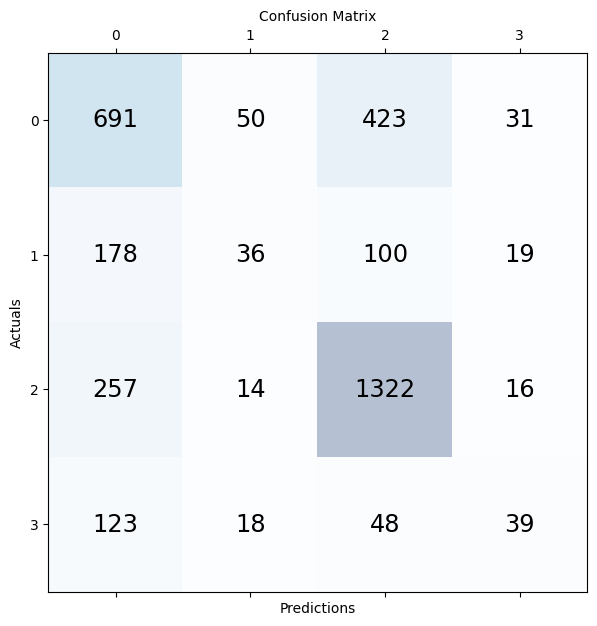

In [27]:
y_pred_test = best_model.predict(X_test_selected)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

In [ ]:
plot_learning_curve(best_model_reduced, X_train_reduced, y_train_val, 'accuracy')

In [ ]:
plot_learning_curve(best_model_reduced, X_train_reduced, y_train_val, 'f1_macro')